<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-dataset" data-toc-modified-id="Import-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import dataset</a></span></li><li><span><a href="#Embeddings-CTNet" data-toc-modified-id="Embeddings-CTNet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Embeddings CTNet</a></span></li><li><span><a href="#Modificar-modelo-para-sacar-cosas" data-toc-modified-id="Modificar-modelo-para-sacar-cosas-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modificar modelo para sacar cosas</a></span></li><li><span><a href="#One-graph-embedding" data-toc-modified-id="One-graph-embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>One graph embedding</a></span></li><li><span><a href="#All-graphs-embedding" data-toc-modified-id="All-graphs-embedding-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>All graphs embedding</a></span></li><li><span><a href="#DIGL" data-toc-modified-id="DIGL-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>DIGL</a></span></li></ul></div>

Para CTNet, MinCutNet, GapNet and DIGL (4 figuras de cada task): 
- [ ] Embeddings de un grafo solo *conv2* -> dispersión
    * Seleccionar grafo que tenga buen accuracy y cambie más la predicción respecto a baseline
    * Train vs test
- [ ] Embeddings de to los grafos (después del readout) pa plotearlo todos juntos y que se vea la separación entre clases
    * Train vs test
- [ ] Grafo con ejes con peso CT matrix en CTNet
    * Seleccionar grafo que tenga buen accuracy y cambie más la predicción respecto a baseline
    * Train vs test
- [ ] Grafo con ejes adjacency modificada en GapNet
    * Seleccionar grafo que tenga buen accuracy y cambie más la predicción respecto a baseline
    * Train vs test
- [X] Datos sobre grafos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from nets import CTNet, GAPNet

import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from transform_features import FeatureDegree
from torch_geometric.datasets import TUDataset

import torch.nn as nn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
@torch.no_grad()
def test(modelo, loader, device):
    modelo.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        pred, mc_loss, o_loss = modelo(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)


## Import dataset

In [602]:
"""dataset = TUDataset(root='data_colab/TUDataset',name="REDDIT-BINARY", pre_transform=FeatureDegree(), use_node_attr=True)
BATCH_SIZE = 64
num_of_centers = 420"""

dataset = TUDataset(root='data_colab/TUDataset',name="MUTAG")
BATCH_SIZE = 32
num_of_centers = 17

In [603]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}, {dataset.num_node_features}, {dataset.num_node_attributes}')
print(f'Number of classes: {dataset.num_classes}')
#dataset = dataset.shuffle()
print()
datum = dataset[0]  # Get the first graph object.
print(datum)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {datum.num_nodes}')
print(f'Number of edges: {datum.num_edges}')
print(f'Average node degree: {datum.num_edges / datum.num_nodes:.2f}')
print(f'Has isolated nodes: {datum.has_isolated_nodes()}')
print(f'Has self-loops: {datum.has_self_loops()}')
print(f'Is undirected: {datum.is_undirected()}')


print(dataset)

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7, 7, 0
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True
MUTAG(188)


In [604]:
loader =  DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Embeddings CTNet

**Probar modelo guardaddo**

In [585]:
modelito = "models/REDDIT-BINARY_CTNet_iter0.pth"
modelito = "models/MUTAG_CTNet_iter0.pth"

In [260]:
#Epoch: 059, Train Loss: 165.455, Train Acc: 0.711, Test Loss: 150.841, Test Acc: 0.750
model =  CTNet(dataset.num_features, dataset.num_classes, k_centers=num_of_centers).to(device)
model.load_state_dict(torch.load(modelito, map_location=torch.device(device)))
model.eval()

CTNet(
  (conv1): DenseGraphConv(32, 32)
  (conv2): DenseGraphConv(32, 32)
  (pool1): Linear(in_features=32, out_features=17, bias=True)
  (pool2): Linear(in_features=32, out_features=16, bias=True)
  (lin1): Linear(in_features=7, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=2, bias=True)
)

In [261]:
loss, acc = test(model, loader, device)

In [262]:
loss, acc

(tensor(21.8395), 0.851063829787234)

## Modificar modelo para sacar cosas

In [263]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import DenseGraphConv
from torch_geometric.utils import to_dense_batch, to_dense_adj
from CT_layer import dense_CT_rewiring
from MinCut_Layer import dense_mincut_pool

In [264]:
class CTNet_embedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, k_centers, hidden_channels=32):
        super(CTNet_embedding, self).__init__()
    
        self.lin1 = Linear(in_channels, hidden_channels)
        num_of_centers1 =  k_centers # k1 #order of number of nodes
        self.pool1 = Linear(hidden_channels, num_of_centers1)
        #self.CT = CTLayer()
        self.conv1 = DenseGraphConv(hidden_channels, hidden_channels)
        num_of_centers2 =  16 # k2 #mincut 
        self.pool2 = Linear(hidden_channels, num_of_centers2)
        #self.MinCut = MinCutLayer()
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels) # MLPs towards out 
        self.lin3 = Linear(hidden_channels, out_channels)
        self.emb = torch.zeros(0)#Creamos la variable que recoge nuestros embedings
        self.emb2 = torch.zeros(0)#Creamos la variable que recoge nuestros embedings

    def forward(self, x, edge_index, batch):    # x torch.Size([N, N]),  data.batch  torch.Size([661])  
        # Make all adjacencies of size NxN 
        adj = to_dense_adj(edge_index, batch) # adj torch.Size(B, N, N])
        # Make all x_i of size N=MAX(N1,...,N20), e.g. N=40:
        x, mask = to_dense_batch(x, batch) # x torch.Size([20, N, 32]) ; mask torch.Size([20, N]) batch_size=20

        x = self.lin1(x)
        # First mincut pool for computing Fiedler adn rewire 
        s1  = self.pool1(x)

        if torch.isnan(adj).any():
            print("adj nan")
        if torch.isnan(x).any():
            print("x nan")
        
        # CT REWIRING
        adj, CT_loss, ortho_loss1 = dense_CT_rewiring(x, adj, s1, mask) # out: x torch.Size([20, N, F'=32]),  adj torch.Size([20, N, N])

        # CONV1: Now on x and rewired adj: 
        x = self.conv1(x, adj) #out: x torch.Size([20, N, F'=32])

        # MLP of k=16 outputs s
        s2 = self.pool2(x) # s torch.Size([20, N, k])
        
        # MINCUT_POOL
        x, adj, mincut_loss2, ortho_loss2 = dense_mincut_pool(x, adj, s2, mask) # out x torch.Size([20, k=16, F'=32]),  adj torch.Size([20, k2=16, k2=16])

        # CONV2: Now on coarsened x and adj: 
        x = self.conv2(x, adj) #out x torch.Size([20, 16, 32])
        
        
        # Readout for each of the 20 graphs
        x = x.sum(dim=1) # x torch.Size([20, 32])
        
        #Queremos esta x, por lo que nos la guardamos
        self.emb = x
        
        # Final MLP for graph classification: hidden channels = 32
        x = F.relu(self.lin2(x)) # x torch.Size([20, 32])
        x = self.lin3(x) #x torch.Size([20, 2])
        self.emb2 = x
        #print(x.shape)
        
        CT_loss = CT_loss + ortho_loss1
        mincut_loss = mincut_loss2 + ortho_loss2
        return F.log_softmax(x, dim=-1), CT_loss, mincut_loss


In [265]:
model =  CTNet_embedding(dataset.num_features, dataset.num_classes, k_centers=num_of_centers).to(device)
model.load_state_dict(torch.load(modelito, map_location=torch.device(device)))
model.eval()

CTNet_embedding(
  (lin1): Linear(in_features=7, out_features=32, bias=True)
  (pool1): Linear(in_features=32, out_features=17, bias=True)
  (conv1): DenseGraphConv(32, 32)
  (pool2): Linear(in_features=32, out_features=16, bias=True)
  (conv2): DenseGraphConv(32, 32)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=2, bias=True)
)

**Test modificado que coja los embeddings**

In [266]:
embedings = []
test_predictions = []
test_predictions2 = []
@torch.no_grad()
def test_embedd(modelo, loader, device):
    test_embeddings = torch.zeros(16,32)
    test_embeddings2 = torch.zeros(16,32)
    modelo.eval()
    correct = 0
    for i,data in enumerate(loader):
        data = data.to(device)
        pred, mc_loss, o_loss = modelo(data.x, data.edge_index, data.batch)
        test_predictions.extend(pred.max(dim=1)[1].tolist())
        #print(pred.max(dim=1)[1].tolist())
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()
        embedings.append(modelo.emb)
        #print(modelo.emb.shape)
        if i == 0:
            test_embeddings = modelo.emb
            test_embeddings2 = modelo.emb2
        else:
            test_embeddings = torch.cat((test_embeddings,modelo.emb.detach().cpu()), 0)
            test_embeddings2 = torch.cat((test_embeddings2,modelo.emb2.detach().cpu()), 0)
        
        #print(modelo.emb.shape)
    return loss, correct / len(loader.dataset),test_embeddings,test_embeddings2

In [267]:
import numpy as np
loss, acc,embeddings,embeddings2 = test_embedd(model, loader, device)
#print(embedings)
#print(test_embeddings)
print("Hwllo there",embeddings.shape)
test_embeddings = embeddings
#Ahora necesitamos quitar el primero que esta lleno de 0s
#Solo faltaría cargarnos el batch
test_embeddings_final = test_embeddings
test_embeddings = test_embeddings
test_embeddings2 = embeddings2
print(test_embeddings_final.shape)
len(test_predictions)

Hwllo there torch.Size([188, 32])
torch.Size([188, 32])


188

In [268]:
loss, acc

(tensor(21.7572), 0.8563829787234043)

/Users/ahmedbegga/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/ahmedbegga/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.000s...
[t-SNE] Computed neighbors for 188 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 1.660219
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.105614
[t-SNE] KL divergence after 1000 iterations: 0.137825


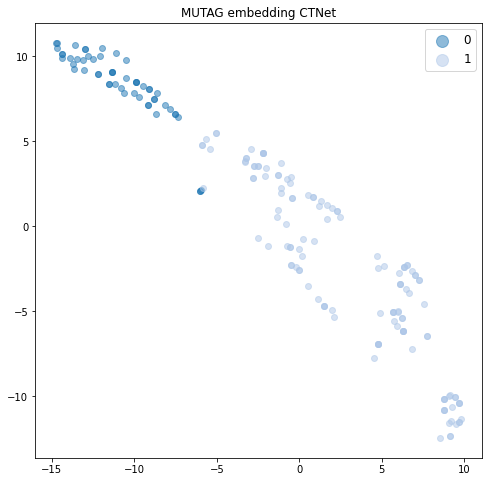

In [269]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import cm
test_embeddings = np.array(test_embeddings_final)
test_predictions = np.array(test_predictions)
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 2
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.title("MUTAG embedding CTNet")
plt.show()

/Users/ahmedbegga/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/ahmedbegga/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.000s...
[t-SNE] Computed neighbors for 188 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 0.298947
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.926670
[t-SNE] KL divergence after 1000 iterations: 0.097908


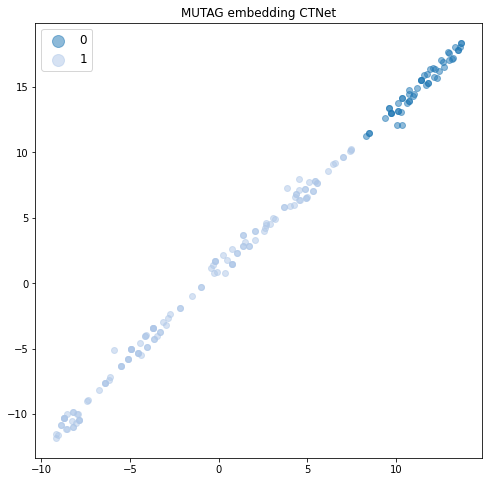

In [254]:
test_embeddings2 = np.array(test_embeddings2)
test_predictions = np.array(test_predictions)
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings2)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 2
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.title("MUTAG embedding CTNet")
plt.show()

/Users/ahmedbegga/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/ahmedbegga/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.000s...
[t-SNE] Computed neighbors for 188 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 1.660219
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.753197
[t-SNE] KL divergence after 1000 iterations: 1.358089


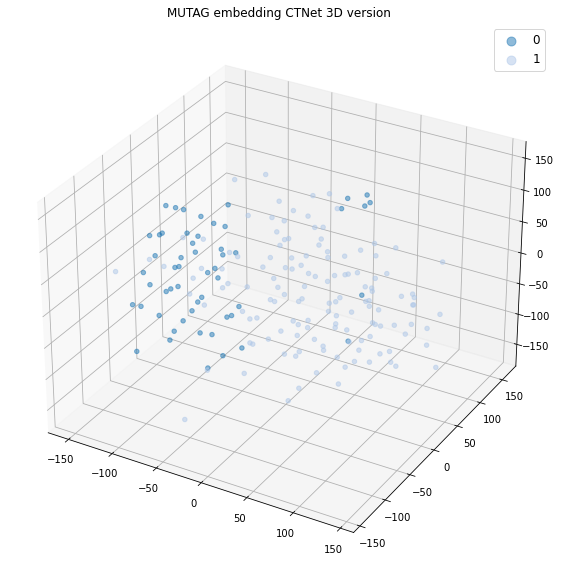

In [270]:
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
cmap = cm.get_cmap('tab20')
num_categories = 2
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1, projection='3d')
for lab in range(num_categories):
    indices = test_predictions == lab
    surf = ax.scatter(
               tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=lab,
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.title("MUTAG embedding CTNet 3D version")
plt.show()

/Users/ahmedbegga/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/ahmedbegga/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.000s...
[t-SNE] Computed neighbors for 188 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 0.298947
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.496841
[t-SNE] KL divergence after 1000 iterations: 1.102306


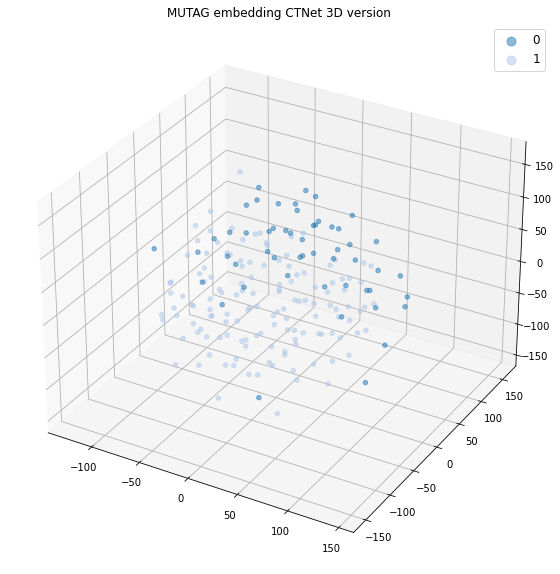

In [258]:
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings2)
cmap = cm.get_cmap('tab20')
num_categories = 2
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1, projection='3d')
for lab in range(num_categories):
    indices = test_predictions == lab
    surf = ax.scatter(
               tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=lab,
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.title("MUTAG embedding CTNet 3D version")
plt.show()

## Descomponemos la red

### Comentarios sobre el código

Lo primero que hacemos es cargar el modelo, y modificar la clase con el truco anterior de coger y guardarnos la adyacencia nueva en una variable.
Lo segundo que hacemos es coger una muestra poniendo el batch a 1 y lo pasamos por la red. Obviamente comprobamos que en esa predicción hemos acertado con la label. Como tenemos ya la predicción, tenemos tambien la adyacencia, que el tensor de esta tiene una dimension de más por el batch, por ello hago el squeeze.
Por último y donde esta el kit de la cuestión, es que tenemos que recoger las nuevas adyacencias y ponerlas en modo de tupla de numpy para plotearlas. La cosa es que le he preguntado a paco que si hay algun umbral o algo y me ha dicho que si y que lo veremos mañana a ver. por eso ves que hay un 0.0234, para quedarnos con las posiciones (x,y) de la matriz de adyacencia

In [605]:
modelito = "models/MUTAG_CTNet_iter0.pth"

In [606]:
class CTNet_toy(torch.nn.Module):
    def __init__(self, in_channels, out_channels, k_centers, hidden_channels=32):
        super(CTNet_toy, self).__init__()
    
        self.lin1 = Linear(in_channels, hidden_channels)
        num_of_centers1 =  k_centers # k1 #order of number of nodes
        self.pool1 = Linear(hidden_channels, num_of_centers1)
        #self.CT = CTLayer()
        self.conv1 = DenseGraphConv(hidden_channels, hidden_channels)
        num_of_centers2 =  16 # k2 #mincut 
        self.pool2 = Linear(hidden_channels, num_of_centers2)
        #self.MinCut = MinCutLayer()
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels) # MLPs towards out 
        self.lin3 = Linear(hidden_channels, out_channels)
        self.emb = torch.zeros(0)#Creamos la variable que recoge nuestros embedings
        self.emb2 = torch.zeros(0)#Creamos la variable que recoge nuestros embedings
        self.edge_rewiring = torch.zeros(0)
        self.min_cut = torch.zeros(0)

    def forward(self, x, edge_index, batch):    # x torch.Size([N, N]),  data.batch  torch.Size([661])  
        # Make all adjacencies of size NxN 
        adj = to_dense_adj(edge_index, batch) # adj torch.Size(B, N, N])
        # Make all x_i of size N=MAX(N1,...,N20), e.g. N=40:
        x, mask = to_dense_batch(x, batch) # x torch.Size([20, N, 32]) ; mask torch.Size([20, N]) batch_size=20

        x = self.lin1(x)
        # First mincut pool for computing Fiedler adn rewire 
        s1  = self.pool1(x)

        if torch.isnan(adj).any():
            print("adj nan")
        if torch.isnan(x).any():
            print("x nan")
        
        # CT REWIRING
        adj, CT_loss, ortho_loss1 = dense_CT_rewiring(x, adj, s1, mask) # out: x torch.Size([20, N, F'=32]),  adj torch.Size([20, N, N])
        self.edge_rewiring = adj 
        # CONV1: Now on x and rewired adj: 
        x = self.conv1(x, adj) #out: x torch.Size([20, N, F'=32])

        # MLP of k=16 outputs s
        s2 = self.pool2(x) # s torch.Size([20, N, k])
        
        # MINCUT_POOL
        x, adj, mincut_loss2, ortho_loss2 = dense_mincut_pool(x, adj, s2, mask) # out x torch.Size([20, k=16, F'=32]),  adj torch.Size([20, k2=16, k2=16])
        self.min_cut = adj 
        # CONV2: Now on coarsened x and adj: 
        x = self.conv2(x, adj) #out x torch.Size([20, 16, 32])
        
        
        # Readout for each of the 20 graphs
        x = x.sum(dim=1) # x torch.Size([20, 32])
        
        #Queremos esta x, por lo que nos la guardamos
        self.emb = x
        
        # Final MLP for graph classification: hidden channels = 32
        x = F.relu(self.lin2(x)) # x torch.Size([20, 32])
        x = self.lin3(x) #x torch.Size([20, 2])
        self.emb2 = x
        #print(x.shape)
        
        CT_loss = CT_loss + ortho_loss1
        mincut_loss = mincut_loss2 + ortho_loss2
        return F.log_softmax(x, dim=-1), CT_loss, mincut_loss


In [607]:
model =  CTNet_toy(dataset.num_features, dataset.num_classes, k_centers=num_of_centers).to(device)
model.load_state_dict(torch.load(modelito, map_location=torch.device(device)))
model.eval()

CTNet_toy(
  (lin1): Linear(in_features=7, out_features=32, bias=True)
  (pool1): Linear(in_features=32, out_features=17, bias=True)
  (conv1): DenseGraphConv(32, 32)
  (pool2): Linear(in_features=32, out_features=16, bias=True)
  (conv2): DenseGraphConv(32, 32)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=2, bias=True)
)

DataBatch(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1], batch=[17], ptr=[2])
17
<Layout with 17 vertices and 3 dimensions>
[(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (3, 9), (4, 5), (4, 6), (6, 7), (7, 8), (8, 9), (8, 13), (9, 10), (10, 11), (11, 12), (12, 13), (12, 14), (14, 15), (14, 16)]


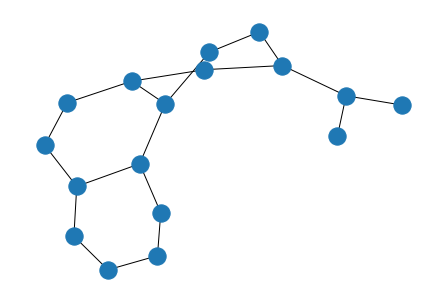

In [608]:
import networkx as nx
from torch_geometric.utils import *
loader =  DataLoader(dataset, batch_size=1, shuffle=False)
grafo_init = next(iter(loader))
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
print(N)
layt=G.layout('kk', dim=3)
print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
print(Edges)
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)

In [609]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="3D graph visualization of Mutag dataset  by : Ahmed",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text="Data source: <a href='https://plotly.com/python/v3/3d-network-graph/</a>",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ],    )

In [610]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')

In [613]:
#modelo(data.x, data.edge_index, data.batch)
print(grafo_init.y)
pred, mc_loss, o_loss = model(grafo_init.x,grafo_init.edge_index,grafo_init.batch)
print(pred.max(dim=1)[1])
print(model.edge_rewiring.shape)
print((model.edge_rewiring.squeeze(0)!=0).sum())
#print(model.edge_rewiring.squeeze(0))
print((model.edge_rewiring.squeeze(0).nonzero()).transpose(0,1).numpy().shape)
kk = model.edge_rewiring.squeeze(0).nonzero().transpose(0,1)
print(kk.size(1))
print(model.edge_rewiring.squeeze(0))
print((model.edge_rewiring.squeeze(0)>0.0241).nonzero())
kk2 = (model.edge_rewiring.squeeze(0)>0.0241).nonzero().transpose(0,1)
#for k in range(kk.size(1)):
#    print("(",kk[0][k].item(),",", kk[1][k].item(),")")

tensor([1])
tensor([1])
torch.Size([1, 17, 17])
tensor(88)
(2, 88)
88
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0234, 0.0235, 0.0235],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0234, 0.0235, 0.0235],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0234, 0.0235, 0.0235],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0234, 0.0235, 0.0235],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0234, 0.0235, 0.0235],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0234, 0.0235, 0.0235],


<class 'torch.Tensor'>
DataBatch(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1], batch=[17], ptr=[2])
DataBatch(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1], batch=[17], ptr=[2])
<Layout with 17 vertices and 3 dimensions>


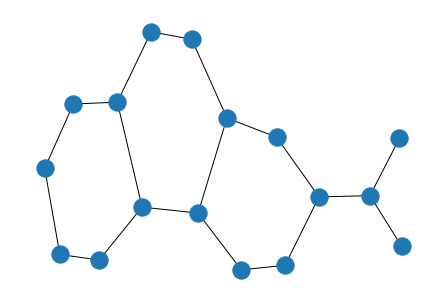

In [617]:
import networkx as nx
from torch_geometric.utils import *
loader =  DataLoader(dataset, batch_size=1, shuffle=False)
grafo_init = next(iter(loader))
print(type(grafo_init.edge_index))
print(grafo_init)
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
#A.edges = kk
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
layt=G.layout('kk', dim=3)
print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
#EN ESTE PASO RECALCO LOS EDGES NUEVOS
Xahmed=[]
Yahmed=[]
Zahmed=[]
for e in Edges:
    if e in kk2.transpose(0,1).numpy():
        Xahmed+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
        Yahmed+=[layt[e[0]][1],layt[e[1]][1], None]
        Zahmed+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)

In [620]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(256,256,256)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
#Lo mismo de antes, estas las pinto de negro y las antiguas de blanco (una pequeña chapuza)
# Vale no, abajo explico como hacerlo sin chapuza
trace3=go.Scatter3d(x=Xahmed,
               y=Yahmed,
               z=Zahmed,
               mode='lines',
               line=dict(color='rgb(0,0,0)', width=1),
               hoverinfo='none'
               )
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="3D graph visualization of Mutag dataset  by : Ahmed",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text="Data source: <a href='https://plotly.com/python/v3/3d-network-graph/</a>",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ],    )

In [624]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
#Si en data no pongo trace1(que son los antiguos edges) no me los imprime y no es una chapuza
data=[ trace2,trace3]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')

## All graphs embedding

# Embeddings GapNet Laplacian

In [ ]:
test_loader =  DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
test_loader =  DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
model =  GAPNet(dataset.num_features, dataset.num_classes, derivative="laplacian",device=device)
model.load_state_dict(torch.load("models/REDDIT-BINARY_GAPNet_laplacian_iter0.pth", map_location=torch.device('cpu')))
model.eval()

# Statistical data about the graph

In [9]:
import networkx as nx
from torch_geometric import utils
import numpy as np
from tqdm.notebook import tqdm


nxdata = {
    'Assortativity':np.empty(len(dataset)),
    'Triangles':np.empty(len(dataset)),
    'Transitivity':np.empty(len(dataset)),
    'Clustering':np.empty(len(dataset))
}
for i, graph in enumerate(tqdm(dataset, desc='Datasets')):
    G = utils.to_networkx(graph, to_undirected=True)
    nxdata['Assortativity'][i] = nx.degree_assortativity_coefficient(G)
    nxdata['Triangles'][i] = np.sum(list(nx.triangles(G).values()))/3
    nxdata['Transitivity'][i] = nx.transitivity(G)
    nxdata['Clustering'][i] = nx.average_clustering(G)


Datasets:   0%|          | 0/2000 [00:00<?, ?it/s]

In [13]:
for k in nxdata:
    print(f"{k}: {nxdata[k].mean():.4f} +- {nxdata[k].std():.4f}")

Assortativity: -0.3635 +- 0.1747
Triangles: 24.8350 +- 41.9040
Transitivity: 0.0097 +- 0.0156
Clustering: 0.0476 +- 0.0639


# Stratify

In [ ]:
from sklearn.model_selection import train_test_split

def class_distrib(dataset):
    d = dict()
    for data in dataset:
        d[int(data.y.numpy())] = d.get(int(data.y.numpy()),0) + 1
    return d

def batch_class_distrib(batch):
    d = dict()
    for label in batch.y:
        d[int(label.numpy())] = d.get(int(label.numpy()),0) + 1
    return d

len(dataset.data.y)

In [ ]:
train_indices, val_indices = train_test_split(list(range(len(dataset.data.y))), test_size=0.2, stratify=dataset.data.y)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

In [ ]:
class_distrib(dataset), class_distrib(train_dataset), class_distrib(val_dataset)

**Optional**

In [ ]:
from torch.utils.data import SequentialSampler

In [ ]:
class StratifiedSampler():
    """Stratified Sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, class_vector, batch_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = int(class_vector.size(0) / batch_size)
        self.class_vector = class_vector

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=0.5)
        X = torch.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index = next(s.split(X, y))
        return np.hstack([train_index, test_index])

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [ ]:
sampler = StratifiedSampler(class_vector=dataset.data.y, batch_size=BATCH_SIZE)


In [ ]:
loader = DataLoader(dataset, batch_size=2, #train_dataset
                        shuffle=False, sampler=sampler)

## DIGL

In [ ]:
import scipy.sparse as sp
from torch_geometric.utils.convert import to_scipy_sparse_matrix, from_scipy_sparse_matrix
from torch_geometric.utils import dense_to_sparse

In [ ]:
from torch_geometric.transforms import BaseTransform

class DIGLedges(BaseTransform):
    def __init__(self, alpha:float, eps:float, use_edge_weigths = False):
        self.alpha = alpha
        self.eps = eps
        self.use_edge_weigths = use_edge_weigths

    def __call__(self, data):
        new_edges, new_weights = self.digl_edges(data.edge_index, self.alpha, self.eps)
        data.edge_index = new_edges
        
        if self.use_edge_weigths:
            data.edge_weight = new_weights
            
        return data
    
    
    def gdc(self, A: sp.csr_matrix, alpha: float, eps: float):
        N = A.shape[0]

        # Self-loops
        A_loop = sp.eye(N) + A

        # Symmetric transition matrix
        D_loop_vec = A_loop.sum(0).A1
        D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
        D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
        T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt

        # PPR-based diffusion
        S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)

        # Sparsify using threshold epsilon
        S_tilde = S.multiply(S >= eps)

        # Column-normalized transition matrix on graph S_tilde
        D_tilde_vec = S_tilde.sum(0).A1
        T_S = S_tilde / D_tilde_vec

        return T_S

    def digl_edges(self, edges, alpha, eps):
        A0 = sp.csr_matrix(to_scipy_sparse_matrix(edges))
        new_sp_matrix = sp.csr_matrix(gdc(A0, self.alpha, self.eps))
        new_edge_index, weights = from_scipy_sparse_matrix(new_sp_matrix)
        return new_edge_index, weights
    
    
    def __repr__(self) -> str:
        return f'{self.__class__.__name__}({self.alpha})'
    
    

In [ ]:
digl_data = TUDataset(root='data/digl/TUDataset',name='MUTAG', transform=DIGLedges(0.5, 0.02))

In [ ]:
digl_data[0].edge_index

In [ ]:
dataset[0].edge_index

In [ ]:
digl_data = TUDataset(root='data/digl/TUDataset',name='MUTAG')

In [ ]:
digl_data[0].edge_index